# Reconstructions using Gauss-Newton method
Here we give an example of reconstructing the conductivity by successive
linearization

## Graph setup
Define graph and graph Laplacian

In [1]:
using Plots, LinearAlgebra, Test, Random
⊗ = kron
Nx = 10; Ny = 10; # number of nodes
x = (0:(Nx-1))*ones(1,Ny)/(Nx-1)
y = ones(Nx)*((0:(Ny-1))') /(Ny-1)
D(N) = [ (i+1==j) - (i==j) for i=1:N-1,j=1:N]
# Discrete gradient
∇ = [ I(Ny) ⊗ D(Nx) # horizontal edges
      D(Ny) ⊗ I(Nx) # vertical edges
]
𝐁 = findall( (x[:].==0) .| (x[:].==1) .| (y[:].==0) .| (y[:].==1))
𝐈 = setdiff(1:Nx*Ny,𝐁)
x𝐄 = abs.(∇)*x[:]/2; y𝐄 = abs.(∇)*y[:]/2 # edge centers
n𝐈 =length(𝐈); n𝐁 = length(𝐁);
n𝐄, n𝐕 = size(∇)
R𝐈 = I(n𝐕)[𝐈,:]  # restriction to interior nodes
R𝐁 = I(n𝐕)[𝐁,:]  # restriction to boundary nodes

indisk(c,r,x) = (x[1]-c[1])^2 + (x[2]-c[2])^2  <= r^2
σ_true =
   [ 1 + indisk((0.2,0.2),0.1,(x,y)) +
     -0.5indisk((0.5,0.5),0.2,(x,y)) +
        2indisk((0.75,0.6),0.2,(x,y))
    for  (x,y) ∈ zip(x𝐄,y𝐄) ]
σ0 = ones(n𝐄)

L(σ) = ∇'*diagm(σ)*∇ # Laplacian

L (generic function with 1 method)

## Boundary conditions and data
The Dirichlet boundary conditions we use are similar to $x + y$ and $x-y$ in
the continuum. They are on purpose not aligned with the grid edges, so that we
do not end up with edges where there are no currents flowing.

In [2]:
fs = [x[𝐁]+y[𝐁] x[𝐁]-y[𝐁]]; N = size(fs,2)

# Dirichlet problem solve
function dirsolve(σ,f)
    u = zeros(n𝐕)
    u[𝐁] = f
    u[𝐈] = -L(σ)[𝐈,𝐈]\(L(σ)[𝐈,𝐁]*f)
    return u
end

function state(σ)
    us = hcat([ dirsolve(σ,f) for f ∈ eachcol(fs)]...)
    Hs = hcat([ σ.*abs2.(∇*u) for u ∈ eachcol(us)]...)
    return us,Hs
end
us_true, Hs_true = state(σ_true) # true data
us0, Hs0 = state(σ0); #  data for a reference conductivity (constant)

## Plot conductivity

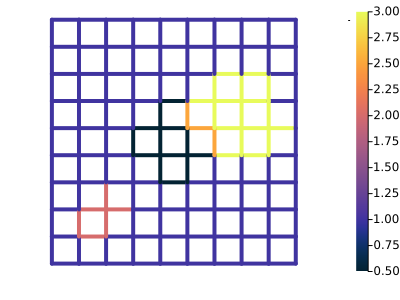

In [3]:
function plot_edge_quantity(f;lw=6,clims=extrema(f))
    p = plot()
    minf, maxf = clims
    for (i, r) in enumerate(eachrow(∇))
      i1, i2 = findall(abs.(r) .> 0)
      if (maxf-minf)/(maxf+minf) < 1e-6
        c = "black"
      else
        c = get(cgrad(:thermal),(f[i]-minf)/(maxf-minf))
      end
      plot!(p,[x[i1], x[i2]], [y[i1], y[i2]], linecolor=c, lw=lw)
    end
    plot!(p,legend=:none, aspect_ratio=:equal, axis=false, grid=false)
    return p
  end

  h2 = scatter([0,0], [0,1], zcolor=[0,1], clims=extrema(σ_true),
                 xlims=(1,1.1), label="", c=:thermal, framestyle=:none)
  l = @layout [ a b{0.1w} ]
  p = plot(
    plot_edge_quantity(σ_true,lw=4), h2,
    layout=l, size=(400,300)
  )

## Plot voltages

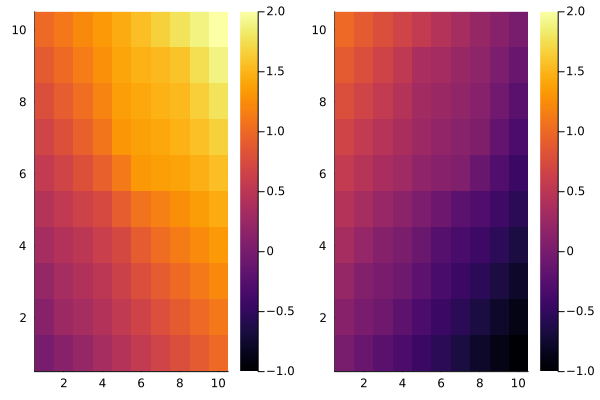

In [4]:
clims = extrema(us_true)
p = plot(
  heatmap(reshape(us_true[:,1],Nx,Ny),clims=clims),
  heatmap(reshape(us_true[:,2],Nx,Ny),clims=clims),
  layout=grid(1,2)
)

## Plot dissipated power

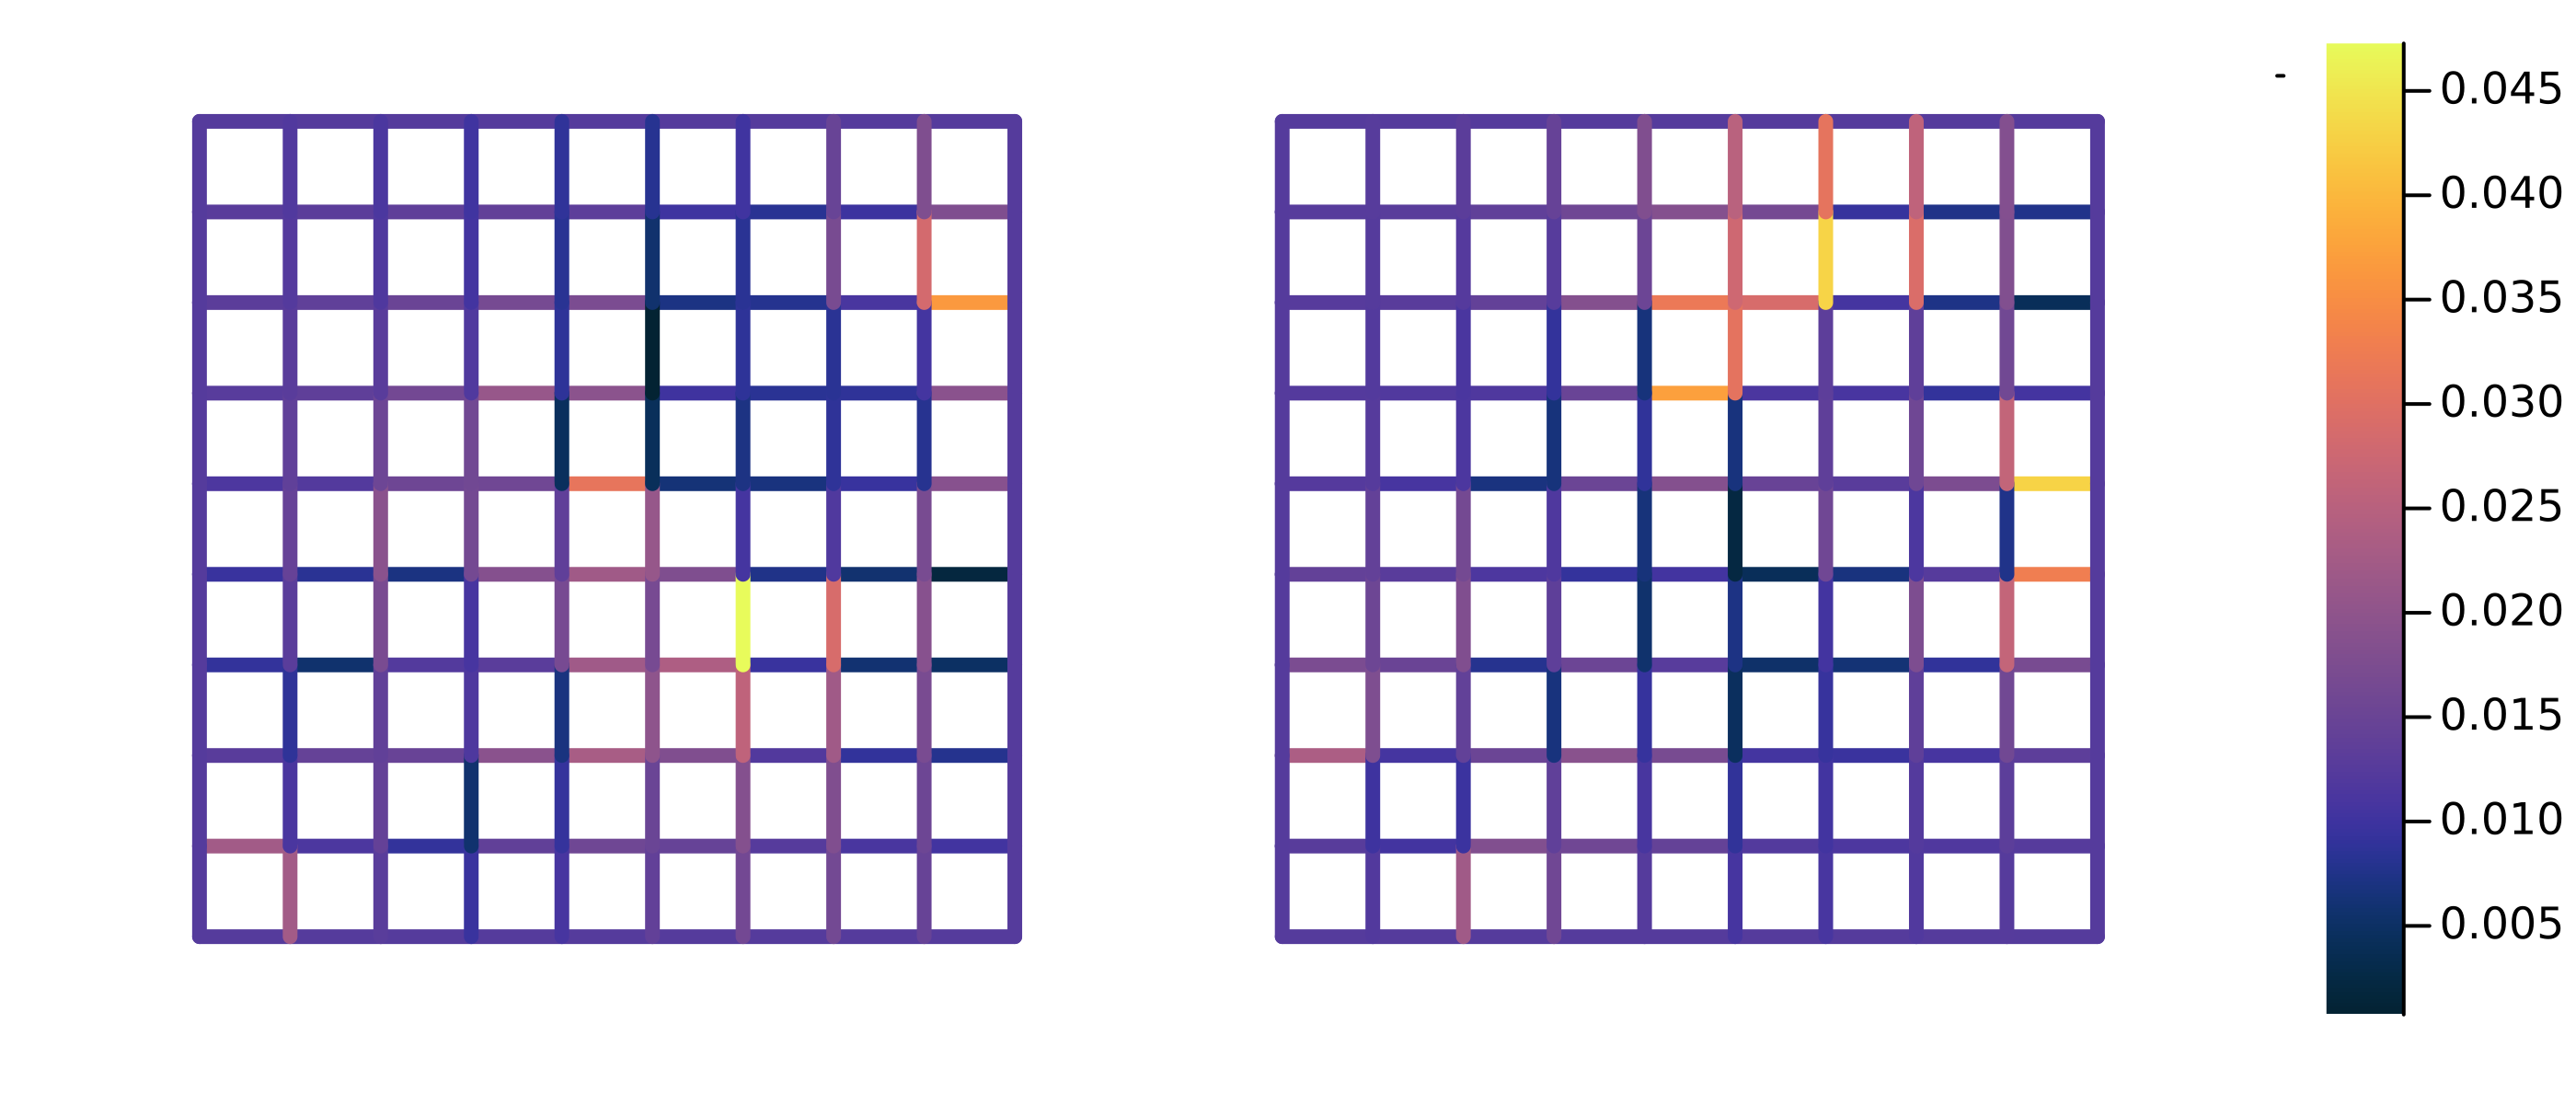

In [5]:
Hclims = extrema(Hs_true)
dpi=400; h=1*dpi; cw = h/4;
h2 = scatter([0,0], [0,1], zcolor=[0,1], clims=Hclims,
               xlims=(1,1.1), label="", c=:thermal, framestyle=:none,
               size=(cw,h),dpi=dpi)
l = @layout [ a b c{0.1w} ]
p1 = plot_edge_quantity(Hs_true[:,1],lw=4,clims=Hclims)
plot!(p1,size=(h,h),dpi=dpi)
p2 = plot_edge_quantity(Hs_true[:,2],lw=4,clims=Hclims)
plot!(p2,size=(h,h),dpi=dpi)

# output
savefig(h2,"dissipated_power_cbar.png")
savefig(p1,"dissipated_power1.png")
savefig(p2,"dissipated_power2.png")
plot(p1,p2,h2,layout=l, size=(700,300))

## Jacobian computation

In [6]:
# Forward problem and Jacobian for one measurement
ℒ(σ,u) = [ (L(σ)*u)[𝐈]
            u[𝐁] ]
ℳ(σ,u) = σ .* abs2.(∇*u)

Dℒ(σ,u) = [
    R𝐈*∇'*diagm(∇*u)  R𝐈*L(σ)
    zeros(n𝐁,n𝐄)      R𝐁
]

Dℳ(σ,u) = [ diagm(abs2.(∇*u)) 2diagm(σ .* (∇*u))*∇ ];

# Assemble forward map
fwd(σ,us) = [ vcat([ℒ(σ,u) for u ∈ eachcol(us)]...)
              vcat([ℳ(σ,u) for u ∈ eachcol(us)]...) ]

# Assemble rhs
rhs(fs,Hs) = [ vec([zeros(n𝐈,N); fs])
               Hs[:] ]

# Assemble Jacobian and injectivity matrix for all boundary conditions
function jacobian(σ,us)
    N = size(us,2) # number of Dirichlet boundary conditions
    Dℒs = [ Dℒ(σ,u) for u ∈ eachcol(us) ]
    Dℳs = [ Dℳ(σ,u) for u ∈ eachcol(us) ]

    # Assemble full Jacobian
    𝒜 = zeros(N*n𝐕+N*n𝐄,n𝐄+N*n𝐕)
    for j=1:N
        𝒜[ (j-1)*n𝐕 .+ (1:n𝐕)        , 1:n𝐄 ] = Dℒs[j][:,1:n𝐄]
        𝒜[ N*n𝐕 .+ (j-1)*n𝐄 .+ (1:n𝐄) , 1:n𝐄 ] = Dℳs[j][:,1:n𝐄]
        𝒜[ (j-1)*n𝐕 .+ (1:n𝐕)        , n𝐄 .+ (j-1)*n𝐕 .+ (1:n𝐕) ] = Dℒs[j][:,n𝐄 .+ (1:n𝐕)]
        𝒜[ N*n𝐕 .+ (j-1)*n𝐄 .+ (1:n𝐄), n𝐄 .+ (j-1)*n𝐕 .+ (1:n𝐕) ] = Dℳs[j][:,n𝐄 .+ (1:n𝐕)]
    end
    return 𝒜
end;

## Gauss-Newton method
Here we solve the optimization problem
$$
\min_x \| R(x) \|^2,
$$
where $R$ is the residual of a (nonlinear) system of equations describing the
problem. The Gauss-Newton method consists of the update:
$$
x^{(n+1)} = x^{(n)} - (DR(x^{(n)})DR^T(x^{(n)}) + \alpha^2 I)^{-1} DR^T(x^{(n)}) R(x^{(n)}),
$$
where $DF(x)$ is the Jacobian of $F$ evaluated at $x$ and $|alpha$ is a
regularization parameter. We add Armijo backtracking to avoid taking steps
that are too large (based on the  unregularized objective function)

In [7]:
function gauss_newton(R,DR,x0;
    maxiter=100,  # max number of GN iterations
    tol=1e-4,     # gradient tolerance
    α=1e-3,       # regularization parameter
    btα=1e-4,     # SDC for backtracking
    β=1/2,        # Armijo factor
    btmaxiter=100 # backtracking max iter
)
    x = x0
    objfun = []
    f(x) = norm(R(x))^2  # objective function

    for n=1:maxiter
        J = DR(x)
        r = R(x)
        ∇f = 2J'*r
        push!(objfun,f(x))
        norm(∇f) < tol && return x,objfun
        dx = - (J'*J + α^2*I)\(J'*r) # GN direction
        # backtracking line search
        t = 1; k = 1
        for k=1:btmaxiter
            (f(x+t*dx)-f(x) < btα*t*∇f'*dx) && break
            t*=β
            (k==btmaxiter) && println("Warning: max backtracking limit hit")
        end
        x = x + t*dx
    end
    return x,objfun
end

gauss_newton (generic function with 1 method)

## Setup data and residual
We check numerically whether the Jacobian we calculate satisfies
$$
 F(x + \epsilon \delta x) = F(x) + \epsilon DF(x)\delta x + \mathcal{O}(\epsilon^2).
$$
More concretely, if $\epsilon$ is too large, Taylor's theorem doesn't hold, if
it is too small then we encounter problems with machine precision, so if
divide the purportedly $\mathcal{O}(\epsilon^2)$ terrm by $\epsilon^2$ we
should get something approximately constant (for values of $\epsilon$ that are
neither too big or too small)

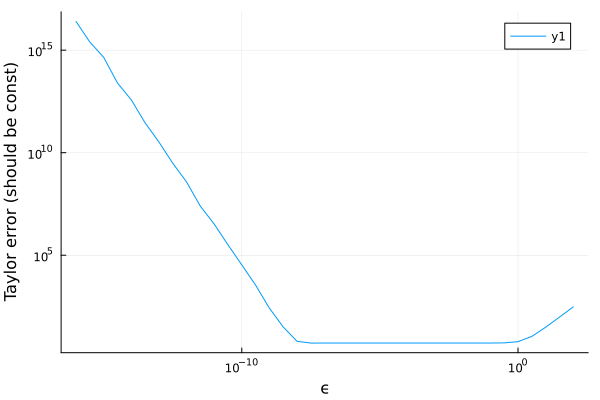

In [8]:
unpack(x)  = (σ=x[1:n𝐄],us=reshape(x[(n𝐄+1):end],n𝐕,N)) # go from x to σ,us
pack(σ,us) = vcat(σ,vec(us)) # go from (σ,us) to x
noiselevel = 5/100
Random.seed!(17) # initialize seed
R(x)  = fwd(unpack(x)...) - rhs(fs,Hs_true)
Rnoisy(x)  = fwd(unpack(x)...) - rhs(fs,Hs_true + maximum(Hs_true)*noiselevel*randn(size(Hs_true)))
DR(x) = jacobian(unpack(x)...)

# test Jacobian against Taylor's theorem
ϵs = 10.0 .^ (2:-0.5:-16)
jacobian_test(F,DF,x0,δx) =
 [ norm(F(x0 + ϵ*δx) - (F(x0) + ϵ*DF(x0)*δx))/ϵ^2/norm(δx) for ϵ ∈ ϵs ]

 plot(ϵs, jacobian_test(R,DR,pack(σ_true,us_true),randn(n𝐄+N*n𝐕)),
      scale=:log10,xlabel="ϵ",ylabel="Taylor error (should be const)")

## Reconstructions with and without noise

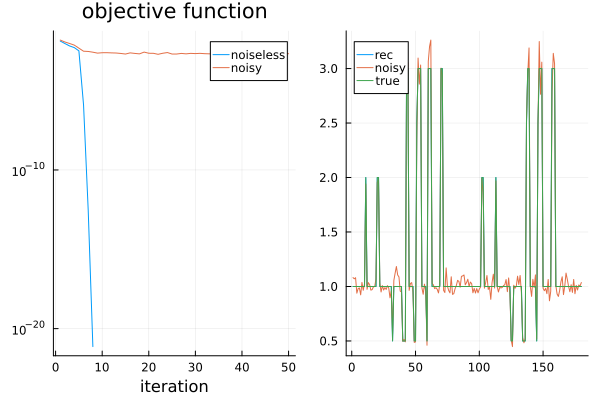

In [9]:
X,objfun1=gauss_newton(R,DR,pack(σ0,us0);α=1e-4,tol=1e-6,maxiter=50)
σrec1,usrec1 = unpack(X)

X,objfun2=gauss_newton(Rnoisy,DR,pack(σ0,us0);α=5e-3,tol=1e-6,maxiter=50)
σrec2,usrec2 = unpack(X)

p1 = plot(objfun1,yscale=:log10,label="noiseless")
plot!(objfun2,title="objective function",label="noisy",xlabel="iteration")
p2 = plot(σrec1,label="rec"); p2=plot!(σrec2,label="noisy"); p2=plot!(σ_true,label="true");
plot(p1,p2,layout=grid(1,2))

## Plot for paper

relative error σrec1 = 3.292531955378804e-8 %
relative error σrec2 = 5.1110841923823935 %


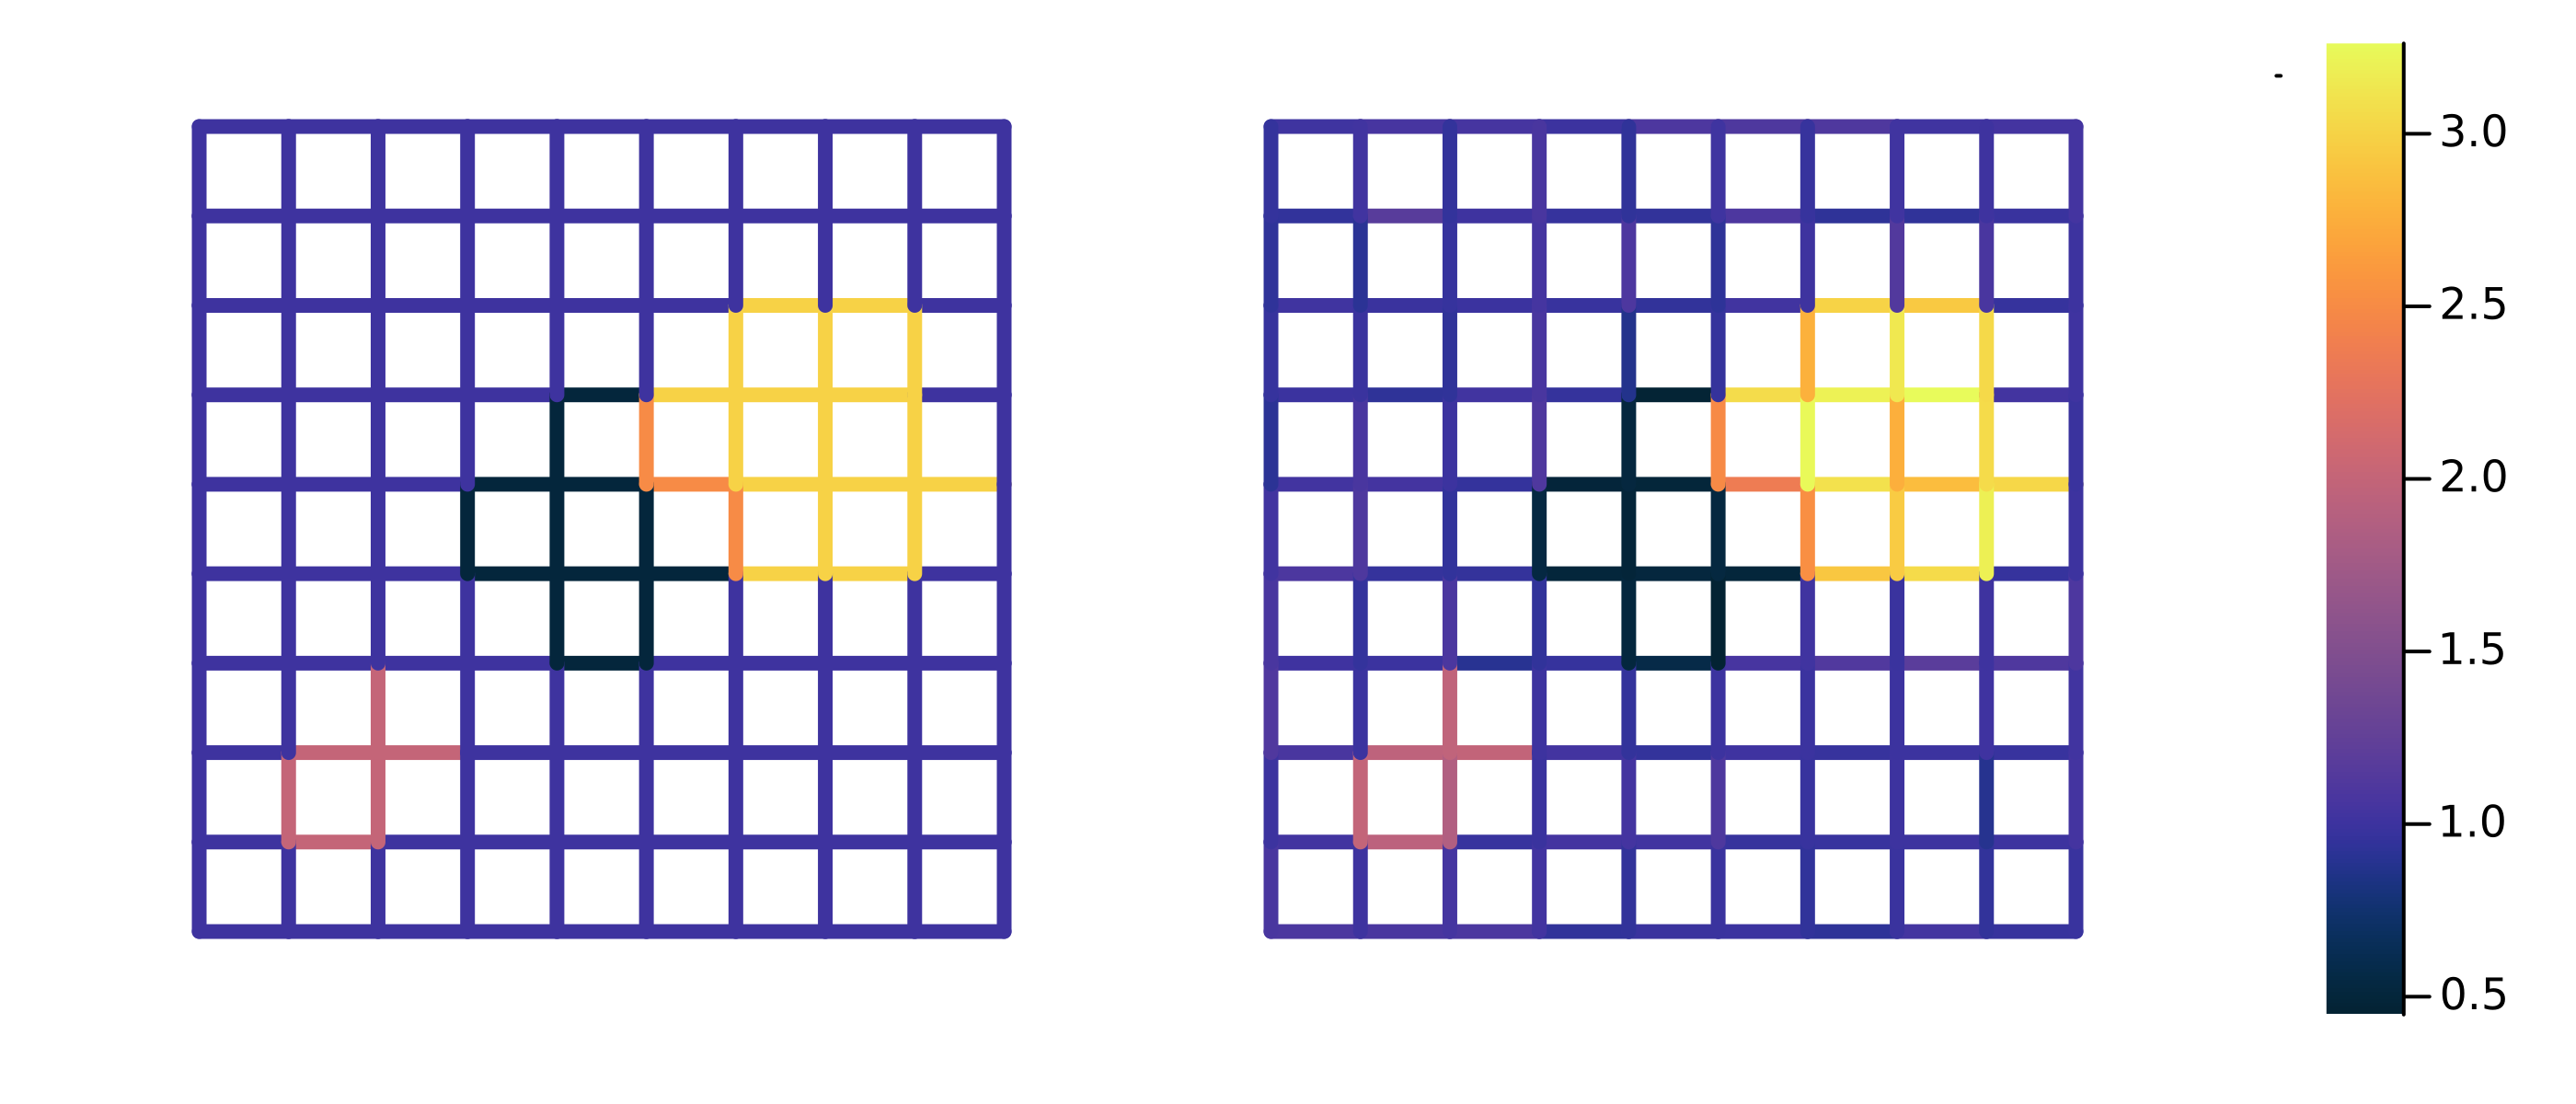

In [10]:
relerr(a,b) = norm(a-b)/norm(a)
println("relative error σrec1 = ",100*relerr(σ_true,σrec1)," %")
println("relative error σrec2 = ",100*relerr(σ_true,σrec2)," %")
clims = extrema([σrec1;σrec2])

l = @layout [ grid(1,2) a{0.1w} ]; dpi=400; h=1*dpi; cw = h/4;
# Colorbar
h2 = scatter([0,0], [0,1], zcolor=[0,1], clims=clims,
                 xlims=(1,1.1), label="", c=:thermal, framestyle=:none,
                 size=(cw,h),dpi=dpi)
p1 = plot_edge_quantity(σrec1,lw=4,clims=clims)
plot!(p1,size=(h,h),dpi=dpi)
p2 = plot_edge_quantity(σrec2,lw=4,clims=clims)
plot!(p2,size=(h,h),dpi=dpi)

# output
savefig(p1,"sigrec_noiseless.png")
savefig(p2,"sigrec_noisy.png")
savefig(h2,"sigrec_cbar.png")
p = plot(p1,p2,h2,layout=l,size=(700,300))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*